## Using Sckit-Learn - Estimators APIs

In this section the data from the data manipulation and feature engineering section will be imported and manipulated one more time in order to run a Logistic regression classifier. The possibility of predicting whether a review is useful or not will be assessed and the model's performance will be measured.

In [1]:
## Import all relevent libraries to analyse the data
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy import stats

## This line makes sure that our graphs are rendered within the notebook
%matplotlib inline

sns.set(color_codes=True)

## Set options to display all columns
pd.set_option("display.max_columns",None)

# load
HelpfulnesswithTarget_df = pd.read_csv('HelpfulnesswithTarget_df.csv', index_col=0)

In [2]:
# Import scikit learn libraries and APIs needed
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

In [5]:
print(HelpfulnesswithTarget_df.dtypes)

Id                           int64
ProductId                   object
UserId                      object
ProfileName                 object
HelpfulnessNumerator         int64
HelpfulnessDenominator       int64
Score                        int64
Time                        object
Summary                     object
Text                        object
helpfulness_ratio          float64
useful_flag                  int64
negative_rating_flag         int64
positive_rating_flag         int64
n_distinct_words             int64
n_words                      int64
clean_text                  object
n_distinct_cleanwords        int64
n_cleanwords                 int64
cleanwords_ratio           float64
day_of_week               category
year                         int64
month                     category
product_freq                 int64
reviewer_freq                int64
winter_flag                  int64
summer_flag                  int64
dtype: object


### 1. Data preparation


First que split the data into a features matrix (X) and target vector (y)

In [4]:
# Setting data type for categorical variables
HelpfulnesswithTarget_df['day_of_week'] = HelpfulnesswithTarget_df['day_of_week'].astype('category') 
HelpfulnesswithTarget_df['month'] = HelpfulnesswithTarget_df['month'].astype('category') 

In [122]:
model_df = HelpfulnesswithTarget_df[['Score'
                                   ,'negative_rating_flag'
                                   ,'positive_rating_flag'
                                   ,'day_of_week'
                                   ,'month'
                                   ,'winter_flag'
                                   ,'summer_flag'
                                   ,'n_words'
                                   ,'product_freq'
                                   ,'reviewer_freq']]

target = HelpfulnesswithTarget_df[['useful_flag']]

Then, we turn each of the categorical variables levels into a bianry variable. Leaving one of the catergies out.

In [123]:
categorical_variables = ['day_of_week', 'month']
for var in categorical_variables: # After the first look of the results I would put this in a function
    categorical_list='var'+'_'+var
    categorical_list = pd.get_dummies(model_df[var], prefix=var, drop_first=True)
    data1=model_df.join(categorical_list)
    model_df=data1
    
data_vars=model_df.columns.values.tolist()
to_keep=[i for i in data_vars if i not in categorical_variables]

model_df=model_df[to_keep]
model_df.head()

,Score,negative_rating_flag,positive_rating_flag,winter_flag,summer_flag,n_words,product_freq,reviewer_freq,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
3,2,1,0,0,0,41,1,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
11,5,0,1,0,1,67,1,3,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
14,5,0,1,0,0,21,2,42,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
15,5,0,1,1,0,26,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
32,4,0,1,1,0,206,5,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


### 2.  Preparing train and test sets

We need to split our data into train and tests sets to measure and compare model performance 

In [124]:
X_train, X_test, y_train, y_test = train_test_split(model_df, target, test_size=0.2, random_state=42)
model_df.shape, X_train.shape, X_test.shape

((124167, 25), (99333, 25), (24834, 25))

It is known from the data exploration section that our target has more reviews tagged as useful (1) and this can bring problems to the model's results and interpretation.  One way to come around this problem is to over sample the not useful reviews, so that the resulted data set has a balanced split of target observations. This will only be done on the training data set as we want to test if the coefficients will give us an accurate prediction on the training set. 

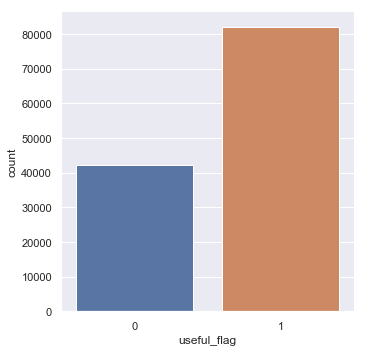

In [125]:
sns.catplot(x="useful_flag", kind="count", data = HelpfulnesswithTarget_df)

In [126]:
# Sampling up none useful reviews using SMOTE (Synthetic Minority Over-sampling Technique)
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=X_train.columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['useful_flag'])

# Check data dimensions
print('length of oversampled data is ',len(os_data_X))
print('Number of useful_flag = 0',len(os_data_y[os_data_y['useful_flag']==0]))
print('Number of useful_flag = 1',len(os_data_y[os_data_y['useful_flag']==1]))

('length of oversampled data is ', 131418)
('Number of useful_flag = 0', 65709)
('Number of useful_flag = 1', 65709)


### 3. Classification modelling Logistic regression
Logistic regression is a classification technique, where the output variable is either binary or a multiclass (categorical variables with different levels, like segments for example) compared to linear regression where the output is a numerical value. 

The main model assumptions are:
- The independent variables should be independent of each other. That is, the model should have little or no multicollinearity.
- The independent variables are linearly related to the output.
- Logistic regression requires quite large sample sizes.

#### Variable selection
First we will assess which variables we can take out of the model by looking at the model summary table and comparing the p-values with an alpha =0.05 (which is I am assuming is the default) The p-values greater than this will indicate the variable should be removed from the model's equation. 
In practice, there are different techniques to select the variables that give the best model performance. Some of these techniques are: Forward selection, backward selection and stepwise selection. It is also important to consider the business or study context. Is the combination of these that gives the best variable selection. 

In [104]:
#should be used to standarise the continuous variables
#StandardScaler().fit_transform(model_df[['product_freq','reviewer_freq','Score']]) 

array([[-0.70901609, -0.23180117, -1.04000497],
       [-0.70901609, -0.23180117,  0.80941186],
       [-0.67365471,  2.48251539,  0.80941186],
       ...,
       [-0.60293195, -0.37099689,  0.80941186],
       [-0.60293195, -0.37099689,  0.19293958],
       [-0.70901609, -0.37099689,  0.80941186]])

In [127]:
# Recursive feature elimination
data_final_vars=model_df.columns.values.tolist()

from sklearn.feature_selection import RFE

logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True False False False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
  True]
[1 1 1 1 1 6 4 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1]


From Scikit learn documentation:
support : array
An index that selects the retained features from a feature vector. If indices is False, this is a boolean array of shape [# input features], in which an element is True if its corresponding feature is selected for retention. If indices is True, this is an integer array of shape [# output features] whose values are indices into the input feature vector.

**statsmodels** is a Python module that provides classes and functions for the estimation of many different statistical models, as well as for conducting statistical tests, and statistical data exploration. (https://www.statsmodels.org/stable/index.html)
This module is useful for checking summary tables and interpreting the model's results, I also like it because it resembles the R output and I am familiar with that. From what I have read, Scikit-Learn does not provide this kind of outputs since it focuses more on the machine learning questions and processes, while Statsmodels focus more on the statistical results. The latter is useful to understand what is happening underneath whilst assesing performance and results; plus it is also needed for interpretation purposes. 

In practice, once I understand a model and its outputs I tend to find a way of optimising the best result by using loops and/or functions via grid searches and arrays using R. In Python the best way will be to use pipelines which will also mean I can talk to the engineering side of the business when talking about implementation and model production. These kind of workflows will output different solutions from where then I can pick the best. The best being the one that gives me the best performance and easy interpretation when taking to my stakeholders; plus it means the model doesn not have to be built from scratch every time and it can be plugged in to some other interface if required. Notebook 3 shows how this model could be implemented in a pipeline

In [128]:
import statsmodels.api as sm

logit_model=sm.Logit(os_data_y,os_data_X)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.535667
         Iterations: 35


C:\Python27\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                  Results: Logit
Model:                    Logit                 Pseudo R-squared:      0.227      
Dependent Variable:       useful_flag           AIC:                   140842.4976
Date:                     2019-06-28 10:58      BIC:                   141087.1511
No. Observations:         131418                Log-Likelihood:        -70396.    
Df Model:                 24                    LL-Null:               -91092.    
Df Residuals:             131393                LLR p-value:           0.0000     
Converged:                0.0000                Scale:                 1.0000     
No. Iterations:           35.0000                                                 
----------------------------------------------------------------------------------
                      Coef.    Std.Err.      z     P>|z|     [0.025       0.975]  
----------------------------------------------------------------------------------
Score                 -0.8064     0.01

The table suggests that some season flags and some months variables to be removed from data. 

In [130]:
# would be better to have this on a function so we see the table just once. 
# columns_notselected=['winter_flag','summer_flag','month_1','month_2','month_4'
#                      ,'month_7','month_8','month_9','month_10','month_11','month_12'] #without using drop-first
columns_notselected=['summer_flag', 'month_7', 'month_8'] #using drop first

columns_OSdata=os_data_X.columns.values.tolist()

columns_tokeep=[i for i in columns_OSdata if i not in columns_notselected]
os_data_Xselected=os_data_X[columns_tokeep]

After taking those variables out, we have a look at the table again

In [131]:
logit_model=sm.Logit(os_data_y,os_data_Xselected)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.551133
         Iterations 6
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.205      
Dependent Variable:  useful_flag       AIC:               144901.5350
Date:                2019-06-28 10:59  BIC:               145116.8301
No. Observations:    131418            Log-Likelihood:    -72429.    
Df Model:            21                LL-Null:           -91092.    
Df Residuals:        131396            LLR p-value:       0.0000     
Converged:           1.0000            Scale:             1.0000     
No. Iterations:      6.0000                                          
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Score                -0.4967   0.0077 -64.2903 0.0000 -0.5118 -0.4816
negative_rating_

From this table, all the variables are significant which means there is no need to take any out anymore. However, it is important to have a model that can be interpreted as well. Model performance and robustness is just as important as interpretation. This last one can be a bit daunting in general for logistic regression due to the nature of the variables. 

The value of the coefficients from 'day of the week' variables are all very similar; meaning there is not a lot of difference between them (which ties up with the data exploration section). It is almost the same case for the months, except from May and the winter months December to February. A review made on the winter months contributes to the useful prediction slightly more than if a review is made in any other month. For example for December the coefficient is 0.6 and for May is 0.39, meaning that if everything else stays the same, a review made on December adds 0.6 to the log of the odds ratio compared to May where it will contirbute 0.39. Odds ratio being the ratio of the review being useful if posted on a specific month. 
Or in simpler terms, if we assume everything else remains the same, reviews made in December and February increase the chances of the review being useful compared to reviews made on May. Which also ties up with what it was shown on the exploration part. 

This can also be extended to the variables related to score. These are shown to be important in predicting whether a review is useful or not, which also makes sense with the data exploration section. The more a reviewer is disatisfied with the product the less useful the review is. 

It would still be useful to have more text mining variables associated with the review to have more information about the reviews itself and it might be the case that the actual content will be assesed better.

#### Model performance

~ Better that ten guilty persons escape than one innocent suffers ~ 

Once the variables that are important are selected and the coefficients are calculated, then the model is fitted on the test set to get the prediction values of th target. Which will allow to compare the predicted results(y's) against the real resutls in order to assess model performance.

In [132]:
# Fitting the model on train set
logreg.fit(os_data_Xselected, os_data_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [133]:
print('The model accuracy on train set is: {:.3f}'.format(logreg.score(os_data_Xselected, os_data_y))) 
#without using drop-first accuracy was 0.77

The model accuracy on train set is: 0.755


In [134]:
# Predicting values in test set
from sklearn import metrics

# selecting only the columns needed in the test set
Xselected_test=X_test[columns_tokeep]

y_pred = logreg.predict(Xselected_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(Xselected_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix:')
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.74
Confusion matrix:
[[ 5662  2785]
 [ 3714 12673]]
              precision    recall  f1-score   support

           0       0.60      0.67      0.64      8447
           1       0.82      0.77      0.80     16387

   micro avg       0.74      0.74      0.74     24834
   macro avg       0.71      0.72      0.72     24834
weighted avg       0.75      0.74      0.74     24834



In [116]:
len(Xselected_test)

24834

From the confusion matrix, the model got 18,335 (5662+12673) predictions right, and 6,499 wrong from a total of 24,834 observations (reviews) on the test set. Which is where the 74% accuracy comes from. 

Looking at precision and recall, 82% of the model's positives and 60% of the negatives were correctly predicted (precision); whilst 77% of the positives observation and 67% of the negatives were predicted correctly. These two metrics are a bit confusing but in general:
- **precision** assesses how many of the predictions are right
- **recall** assesses how many observations did the model get right 

As an example, let's say we have 3 true positives from the model and 4 positive observations. The precision would be 3/3, i.e. all the predictions are correct; whilst the recall is 3/4, i.e. the model missed one of the true observations. 

The importance of these 2 measures depends on the purpose of the study or the business case. For example, in Spam detection usually precision is more important; whilst in medicine and clinical studies recall is more important. Usually these are associated with cost, and one will be more "expensive" than the other depending on the purpose. Hence the phrase I wrote at the beginning of the model performance section. 

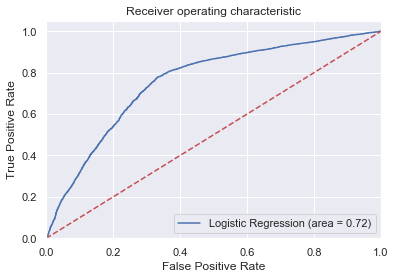

In [135]:
# ROC curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(Xselected_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(Xselected_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The ROC curve is a graphical view of assessing the model's performance. The higher the AUC, better the model is at predicting 0's and 1's. If the ROC resembles the dotted redline too much then the classifier is not good at identifying the 0's and 1's. In this case, the curve does not look too bad. 
An AUC of 0.72  means there is 72% chance that model will be able to distinguish between positive class and negative class.

In [96]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from sklearn.datasets import load_iris

# data = load_iris()
# fig, axes = plt.subplots(nrows=2, ncols=2)
# fig.subplots_adjust(hspace=0.5)
# fig.suptitle('Distributions of Iris Features')

# for ax, feature, name in zip(axes.flatten(), data.data.T, data.feature_names):
#     sns.catplot( data.target_names, feature, kind="box", ax=ax)
#     #sns.distplot(feature, ax=ax, bins=len(np.unique(data.data.T[0]))//2)
#     #sns.catplot(x="negative_rating_flag", y="helpfulness_ratio", kind="box", data=HelpfulnesswithTarget_df,ax=ax)
#     ax.set(title=name[:-4].upper(), xlabel='cm')

In [136]:
# Evaluate the model using 10-fold cross-validation
from sklearn.model_selection  import cross_val_score
scores = cross_val_score(logreg, os_data_Xselected, os_data_y, scoring='accuracy', cv=10)
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.71769898 0.71488358 0.71572059 0.71435094 0.70917669 0.78055091
 0.7909755  0.79173642 0.78709481 0.79550989]
Accuracy: 0.75 (+/- 0.08)


Running a quick 10-fold cross validation algorithm, it is possible to see that this model's accuracy remains around 75% with a small confidence interval, which means it is performing well. 

### 4. Trying a Random Forest just out of curiousity

In [118]:
# Fit Random Forest on training fold 
clf_rf = RandomForestClassifier(n_estimators=500, max_depth=2,
                              random_state=0).fit(os_data_Xselected, os_data_y) #without using drop-first

C:\Python27\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [119]:
y_model = clf_rf.predict(Xselected_test) 

In [120]:
from sklearn.metrics import accuracy_score
print('The Random Forest accuracy is: {:.3f}'.format(accuracy_score(y_test, y_model))) 

The Random Forest accuracy is: 0.751


### 5. Conclusions

- The classifiers have a satisfactory performance and behaviour and are able to predict the reviews 
- Once one model is tested, analysed and understood then, I would put the steps into functions and a pipeline using the scikit learn API so that everything is tied up and one can just change the inital X and y elements. I would try different seeds and see which variables keep getting picked up in the model, to make sure I have tried everything.    
- It would also be possible to test other classifiers and see which one is better or if there is any improvement. This is specilly needed for more complex models when there are millions of rows and many variables. 
- I would have probably tried to predict the usefulness ratio instead of the useful flag, as a ratio of 0.2 is not the same as 0.65 This means that there is a bit of lost information there. In this case I would have probably started with a linear regression, since the output measure is a numerical value. There is also something called a Random Forest Regression, that might be interesting to explore further.  
- Other variables could have been added if there was more data avaiable. For example, product especifications or reviewers' details such as tenure, age or profession. 
- As mentioned before, more text mining variables could have been added as well


=============================================================

In [143]:
# Testing other solvers in logistic regression models ---
#l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization 
# this is the kind of hyperparameter that need to be found via a grid search

# Fit Logistic regression on training fold
#l1_log = LogisticRegression(random_state=0, solver='saga', penalty='l1').fit(os_data_Xselected, os_data_y)
#l2_log = LogisticRegression(random_state=0, solver='saga', penalty='l2').fit(os_data_Xselected, os_data_y)
#en_log = LogisticRegression(random_state=0, solver='saga', penalty='elasticnet',l1_ratio=0.5).fit(os_data_Xselected, os_data_y)

# A note on elastic net: --
# ElasticNet is a linear regression model trained with both l1 and l2-norm regularization of the coefficients. 
# This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, 
# while still maintaining the regularization properties of Ridge. We control the convex combination of l1 and l1 using 
# the l1_ratio parameter.

# Elastic-net is useful when there are multiple features which are correlated with one another. 
#Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.

# A practical advantage of trading-off between Lasso and Ridge is that it allows Elastic-Net to inherit some 
# of Ridge’s stability under rotation.
# so bascially, lasso (l1) works best when we have a lot of variables that are useless and Ridge (l2) works best when we have
# a lot of variables that might not all be useless
# when rho = 1 then elastic net is Lasso

In [46]:
# log_model = LogisticRegression(random_state=0, solver='saga').fit(os_data_Xselected, os_data_y)

In [47]:
# ## Coefficients
# # coef_l1_log = l1_log.coef_.ravel()
# # coef_l2_log = l2_log.coef_.ravel()
# # print(coef_l1_log)
# # print(coef_l2_log)

# pd.DataFrame(zip(X_train.columns, np.transpose(log_model.coef_)))

In [48]:
# print('The model accuracy is: {:.3f}'.format(log_model.score(os_data_Xselected, os_data_y)))

In [44]:
# log_pred = log_model.predict(Xselected_test) #predicting binary outcomes
# log_pred_prob = log_model.predict_proba(Xselected_test) # predicting probabilities